## interplay between nucleosome repair, eviction/redeposition, and transcription
### nicole pagane | roberts lab

In [285]:
import scipy.integrate as snt
from scipy.optimize import leastsq
import matplotlib.pyplot as plt
import numpy as np
import random as rnd
pass

In [286]:
# declare universal constants
NUC_SPACE = 170
NUC_LEN = 140
RNAP_MOVE = 65
HEALTH_CUT = NUC_SPACE/np.sqrt(NUC_SPACE)

In [380]:
# initialize system without further knowledge of isw2 and isw1a mechanisms
# this is derived from results of statistical positioning

# intialize gene
def initializeGene(nucLen = NUC_LEN, avgSpace = NUC_SPACE, geneLen = 2000, constant = 0):
    gene = np.zeros(geneLen)
    ind = 0
    nucNum = 1
    while ind + nucLen < geneLen:
        gene[ind:ind+nucLen] = nucNum
        if constant: 
            spc = constant
        else:
            k = -np.log(0.5)
            y = avgSpace*0.5*np.exp(-k*(ind+nucLen)/geneLen)
            spc = int(avgSpace*1.5 - y)
        ind = ind + nucLen + spc
        nucNum += 1
    return gene

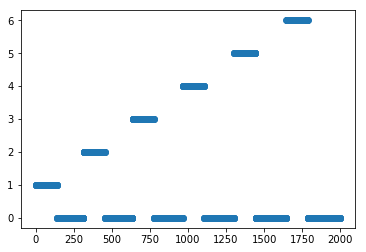

In [381]:
gene = initializeGene()
plt.plot(gene, 'o')
plt.show()

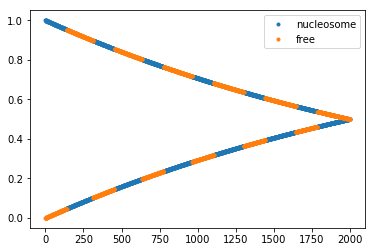

In [382]:
# define gene occupancy expectation
def geneOccupancy(g):
    x = np.linspace(1, len(g), len(g))
    k = -np.log(0.5)
    y = np.exp(-k*x/len(g))
    gScale = np.ceil(g/max(g))*y
    for i in range(len(g)):
        if gScale[i] == 0:
            gScale[i] = 1-y[i]
    return gScale


gRef = geneOccupancy(initializeGene())
plt.plot(gRef, '.', label='nucleosome')
plt.plot(1-gRef, '.', label='free')
plt.legend()
plt.show()

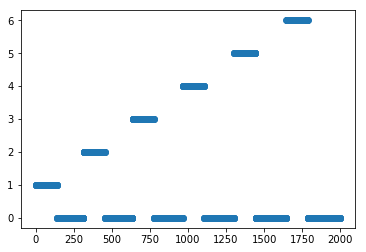

{0.0: 0, 1.0: 175, 2.0: 183, 3.0: 191, 4.0: 198, 5.0: 204, 6.0: 215}


In [384]:
# determine spacing
def detSpace(g):
    gene = np.linspace(0, len(g)-1, len(g))
    space = {}
    nucs = np.unique(g)
    for i in range(len(nucs)):
        lowBound = np.asarray(gene[g==nucs[i-1]], int)
        if nucs[i-1] == 0: lowBound = [0];
        space[nucs[i-1]] = np.asarray(gene[g==nucs[i]], int)[0] - lowBound[-1]
    # append last nuc spacing to end of gene
    space[nucs[-1]] = len(g) - np.asarray(gene[g==nucs[-1]], int)[-1]
    return space

plt.plot(gene, 'o')
plt.show()
print detSpace(gene)

In [330]:
# define energy calculation
def energy(g):
    '''
    # OLD energy
    # determine spacing
    space = detSpace(g).values()
    # compare to exponential distribution
    x = np.linspace(0, len(space)-1, len(space))
    y = NUC_SPACE*np.exp(-x*1.0/len(space)) 
    dist = (y-space)**2
    # bias the weighting to fit the beginning of the nucleosome better
    dist = np.sum(dist*np.exp(-3*x/(len(space)))) # factor of 3 decided randomly tbh
    return dist/len(g)
    '''
    # NEW energy
    dist = (gRef - np.ceil(g/max(g)))**2 # taking into account occupancy at site
    # scale to fit 3prime end better 
    #k = -np.log(0.5); x = np.linspace(0, len(g)-1, len(g))
    #dist = np.sum(dist*np.exp(-k*x/(len(g)))) # factor of 3 decided randomly tbh
    return np.sum(dist)/len(g)

In [331]:
# MCMC to simulate nucleosome shuffling
def MCMC(g = initializeGene(), N = 1000, BF = 1e-3):
    N = int(N)
    gRef = geneOccupancy(g)
    nucN = max(g)
    curE = energy(g)
    eVec = []
    propG = np.zeros(len(g))
    gSum = np.ceil(g/max(g))
    for i in range(N):
        # select random nucleosome
        propNuc = np.random.randint(min(g)+1, nucN+1)
        propInd = np.array(np.linspace(0, len(g)-1, len(g))[g == propNuc], int)
        # select random movement
        propMove = int(np.random.normal(0, np.sqrt(NUC_SPACE))) # sample from normal w spread nuc len
        # implement proposed movement
        move = propInd + propMove
        moveTrim = move[move >= 0]
        move = moveTrim[moveTrim < len(g)]
        # check for collision
        propG = g[:]*1.0 # shallow copy
        propG[propInd] = 0
        if (np.sum(propG[move]) == 0 and len(move) == len(propInd)):
            propG[move] = propNuc
            # metropolis criterion
            propE = energy(propG)
            delE = propE - curE
            rand = np.random.rand()
            if (rand < np.exp(-delE/BF)):
                # accept change
                g = propG[:]*1.0 #shallow copy
                curE = propE
                if (nucN != max(g)):
                    gRef = geneOccupancy(g) # reset reference state
                    nucN = max(g)
            gSum += np.ceil(g/max(g))
            eVec.append(curE)
    return g, eVec, gSum

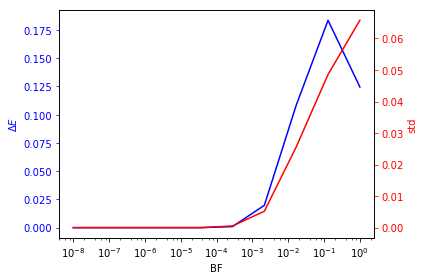

In [332]:
# determining best BF for dummy energy term
BF = np.logspace(-8,0, 10)

delE = []
std = []
for i in BF:
    gene, eVec, null = MCMC(BF = i)
    delE.append(eVec[-1] - eVec[0])
    std.append(np.std(eVec))

    
fig, ax1 = plt.subplots()
ax1.plot(BF, delE, 'b-')
ax1.set_xlabel('BF')
ax1.set_xscale('log')
ax1.set_ylabel(r'$\Delta E$', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(BF, std, 'r-')
ax2.set_ylabel('std', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()

plt.show()

In [333]:
gene = initializeGene(constant = NUC_SPACE)

n1 = 1000; n2 = 5000; n3 = 10000
T = 5e-3
gene1, eVec1, gA1= MCMC(gene, n1, T)
gene2, eVec2, gA2 = MCMC(gene, n2, T)
gene3, eVec3, gA3 = MCMC(gene, n3, T)

allowed moves for 1: 919
allowed moves for 2: 4682
allowed moves for 3: 9400


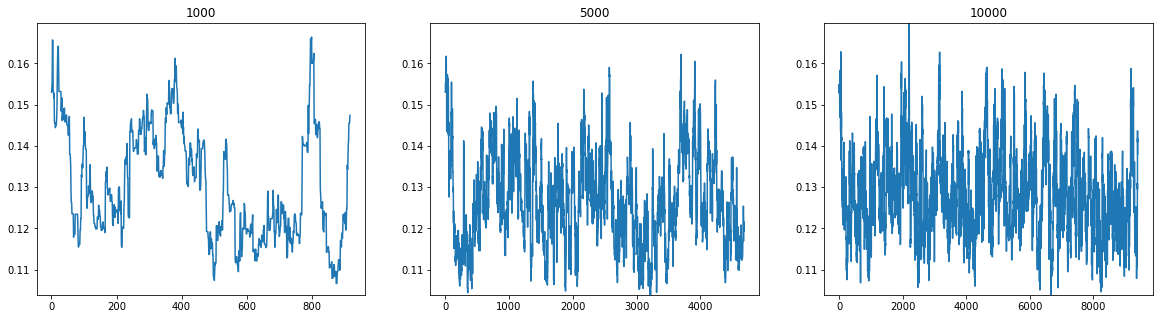

In [334]:
print 'allowed moves for 1: ' + str(len(eVec1))
print 'allowed moves for 2: ' + str(len(eVec2))
print 'allowed moves for 3: ' + str(len(eVec3))

fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,3,1)
ax.set_ylim([min(eVec3), max(eVec3)])
ax.set_title(n1)
ax.plot(eVec1)
ax = fig.add_subplot(1,3,2)
ax.set_ylim([min(eVec3), max(eVec3)])
ax.set_title(n2)
ax.plot(eVec2)
ax = fig.add_subplot(1,3,3)
ax.set_ylim([min(eVec3), max(eVec3)])
ax.set_title(n3)
ax.plot(eVec3)

plt.show()

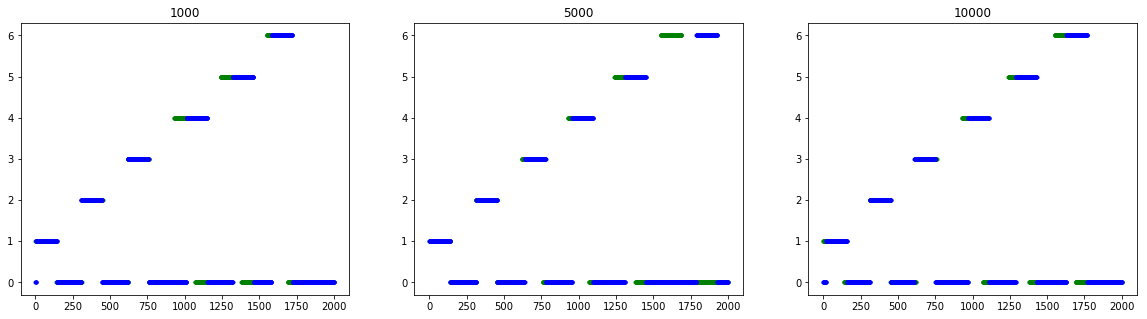

In [335]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,3,1)
ax.set_title(n1)
ax.plot(gene, 'g.')
ax.plot(gene1, 'b.')
ax = fig.add_subplot(1,3,2)
ax.set_title(n2)
ax.plot(gene, 'g.')
ax.plot(gene2, 'b.')
ax = fig.add_subplot(1,3,3)
ax.set_title(n3)
ax.plot(gene, 'g.')
ax.plot(gene3, 'b.')

plt.show()

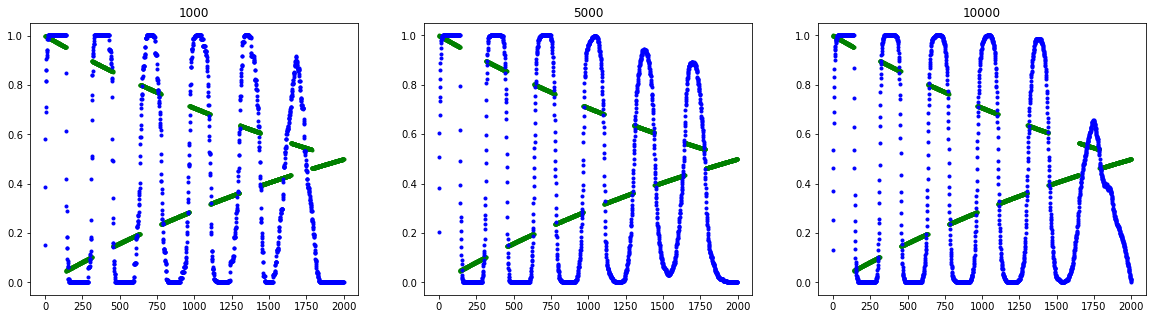

In [336]:
# reference
gRef = geneOccupancy(initializeGene())

fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,3,1)
ax.set_title(n1)
ax.plot(gRef, 'g.')
ax.plot(gA1/len(eVec1), 'b.')
ax = fig.add_subplot(1,3,2)
ax.set_title(n2)
ax.plot(gRef, 'g.')
ax.plot(gA2/len(eVec2), 'b.')
ax = fig.add_subplot(1,3,3)
ax.set_title(n3)
ax.plot(gRef, 'g.')
ax.plot(gA3/len(eVec3), 'b.')

plt.show()

In [337]:
print detSpace(gene)
print ''
print detSpace(gene1)
print detSpace(gene2)
print detSpace(gene3)

{0.0: 0, 1.0: 171, 2.0: 171, 3.0: 171, 4.0: 171, 5.0: 171, 6.0: 311}

{0.0: 4, 1.0: 163, 2.0: 174, 3.0: 254, 4.0: 170, 5.0: 122, 6.0: 279}
{0.0: 0, 1.0: 176, 2.0: 185, 3.0: 179, 4.0: 215, 5.0: 339, 6.0: 72}
{0.0: 19, 1.0: 155, 2.0: 159, 3.0: 220, 4.0: 181, 5.0: 200, 6.0: 232}


In [385]:
# define RNAP passage effects
def RNAP(g):
    spc = detSpace(g)
    temp = g[:]*1.0
    for i in spc.keys():
        if (i != max(g) and spc[i] < RNAP_MOVE):
            nuc = np.asarray(np.linspace(0, len(g)-1, len(g))[g==i+1], int)
            temp = g[:]*1.0
            temp[nuc] = 0
            temp[nuc - spc[i]+1] = g[nuc]
        elif (i != max(g)):
            nuc = np.asarray(np.linspace(0, len(g)-1, len(g))[g==i+1], int)
            temp = g[:]*1.0
            temp[nuc] = 0
            temp[nuc - RNAP_MOVE] = g[nuc]
        g = temp
        spc = detSpace(g)
    return g

In [391]:
cycles = 10
gene = []
en = []
g = initializeGene(); gene.append(g)
gAv = []
for i in range(cycles):
    g = RNAP(g); gene.append(g); en.append(energy(g)); gAv.append(np.ceil(g/max(g)))
    print 'transcription ', i+1, ': ', detSpace(g).values()
    g, e, gA = MCMC(g, 500, T); gene.append(g); en.extend(e); gAv.append(gA/len(e))
    print 'relaxation ', i+1, ': ', detSpace(g).values(), ' with ', len(e), ' attempts'

transcription  1 :  [1, 109, 183, 191, 198, 204, 280]
relaxation  1 :  [4, 162, 202, 127, 232, 240, 199]  with  482  attempts
transcription  2 :  [1, 100, 202, 127, 232, 240, 264]
relaxation  2 :  [2, 167, 191, 179, 230, 167, 230]  with  471  attempts
transcription  3 :  [1, 103, 191, 179, 230, 167, 295]
relaxation  3 :  [0, 172, 188, 185, 201, 214, 206]  with  479  attempts
transcription  4 :  [1, 106, 188, 185, 201, 214, 271]
relaxation  4 :  [14, 165, 201, 160, 198, 193, 235]  with  465  attempts
transcription  5 :  [1, 113, 201, 160, 198, 193, 300]
relaxation  5 :  [2, 168, 190, 169, 197, 12, 428]  with  462  attempts
transcription  6 :  [1, 104, 190, 169, 197, 12, 493]
relaxation  6 :  [1, 174, 185, 186, 121, 32, 467]  with  431  attempts
transcription  7 :  [1, 109, 185, 186, 121, 32, 532]
relaxation  7 :  [4, 185, 170, 164, 161, 15, 467]  with  448  attempts
transcription  8 :  [1, 123, 170, 164, 161, 15, 532]
relaxation  8 :  [0, 165, 203, 202, 21, 12, 563]  with  449  attempts

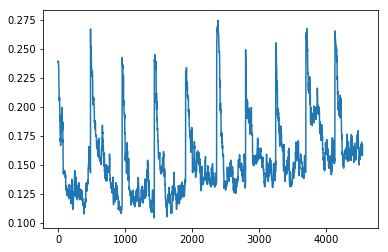

In [392]:
plt.plot(en)
plt.show()

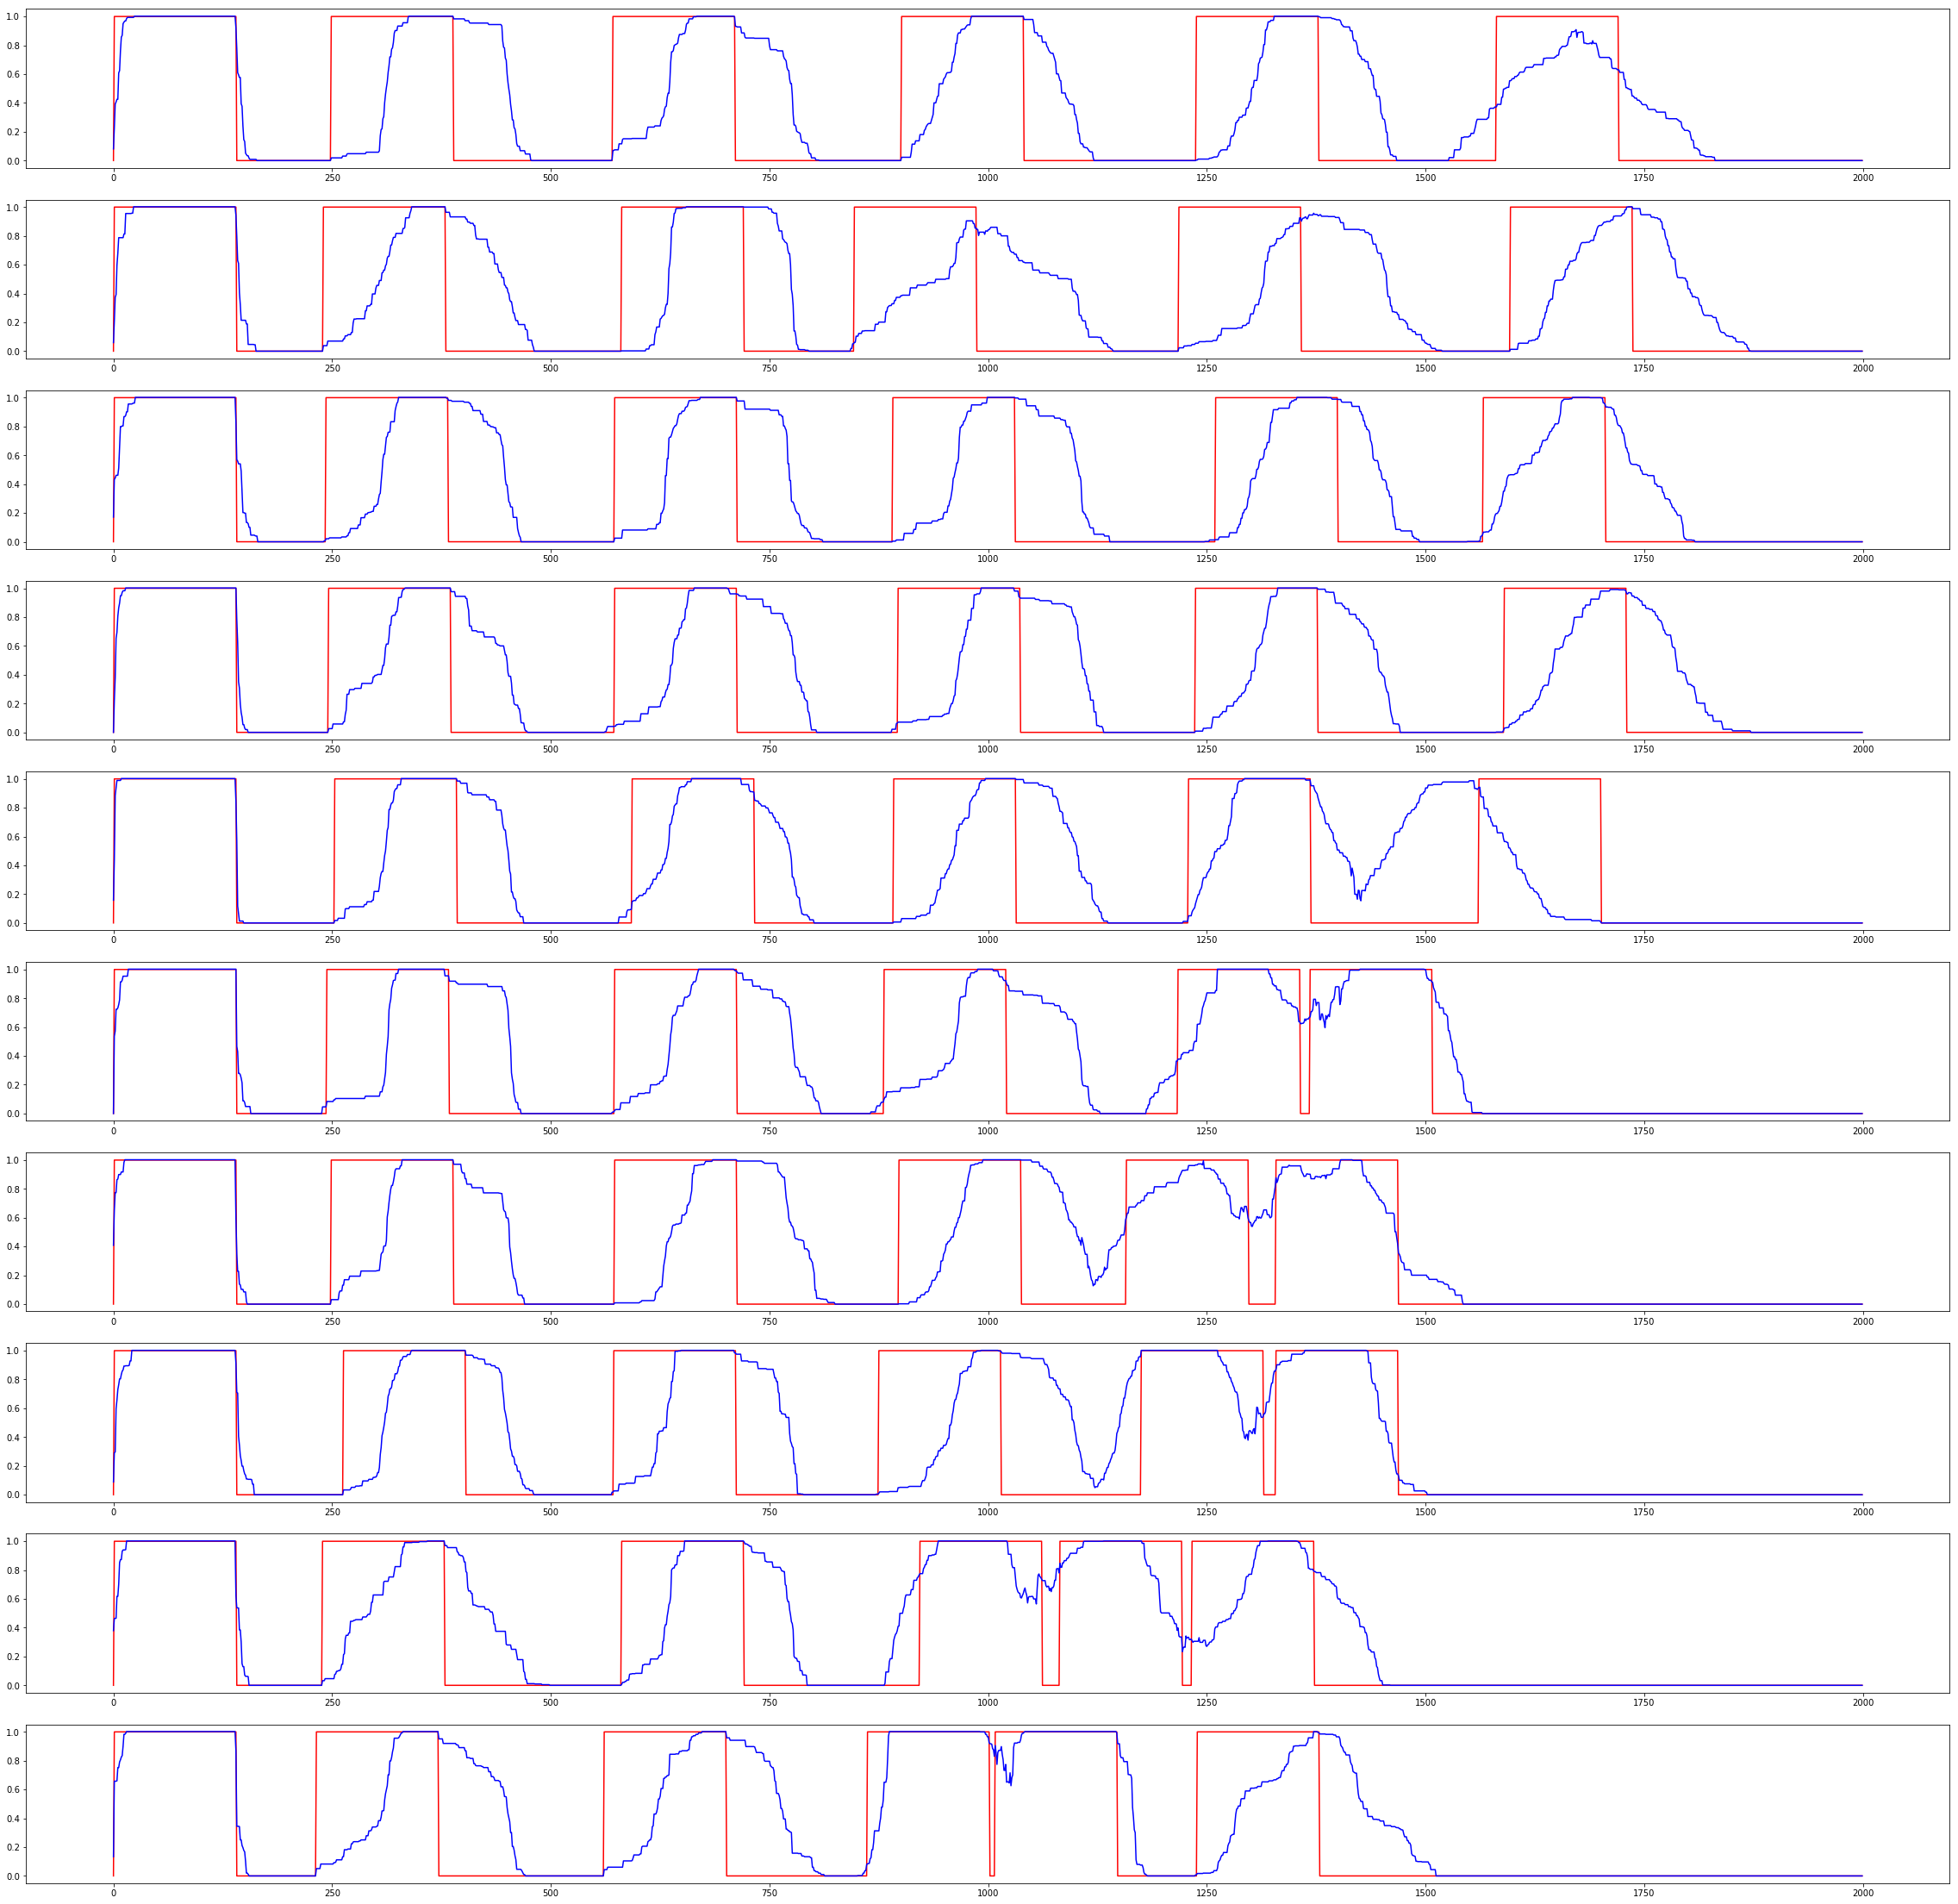

In [393]:
fig = plt.figure(figsize=(4*cycles, 4*cycles))
ind = 0; pltInd = 0
while ind < 2*cycles:
    ax = fig.add_subplot(cycles,1,pltInd+1)
    ax.plot(gAv[ind], 'r-')
    ax.plot(gAv[ind+1], 'b-')
    ind += 2; pltInd += 1
    
plt.show()

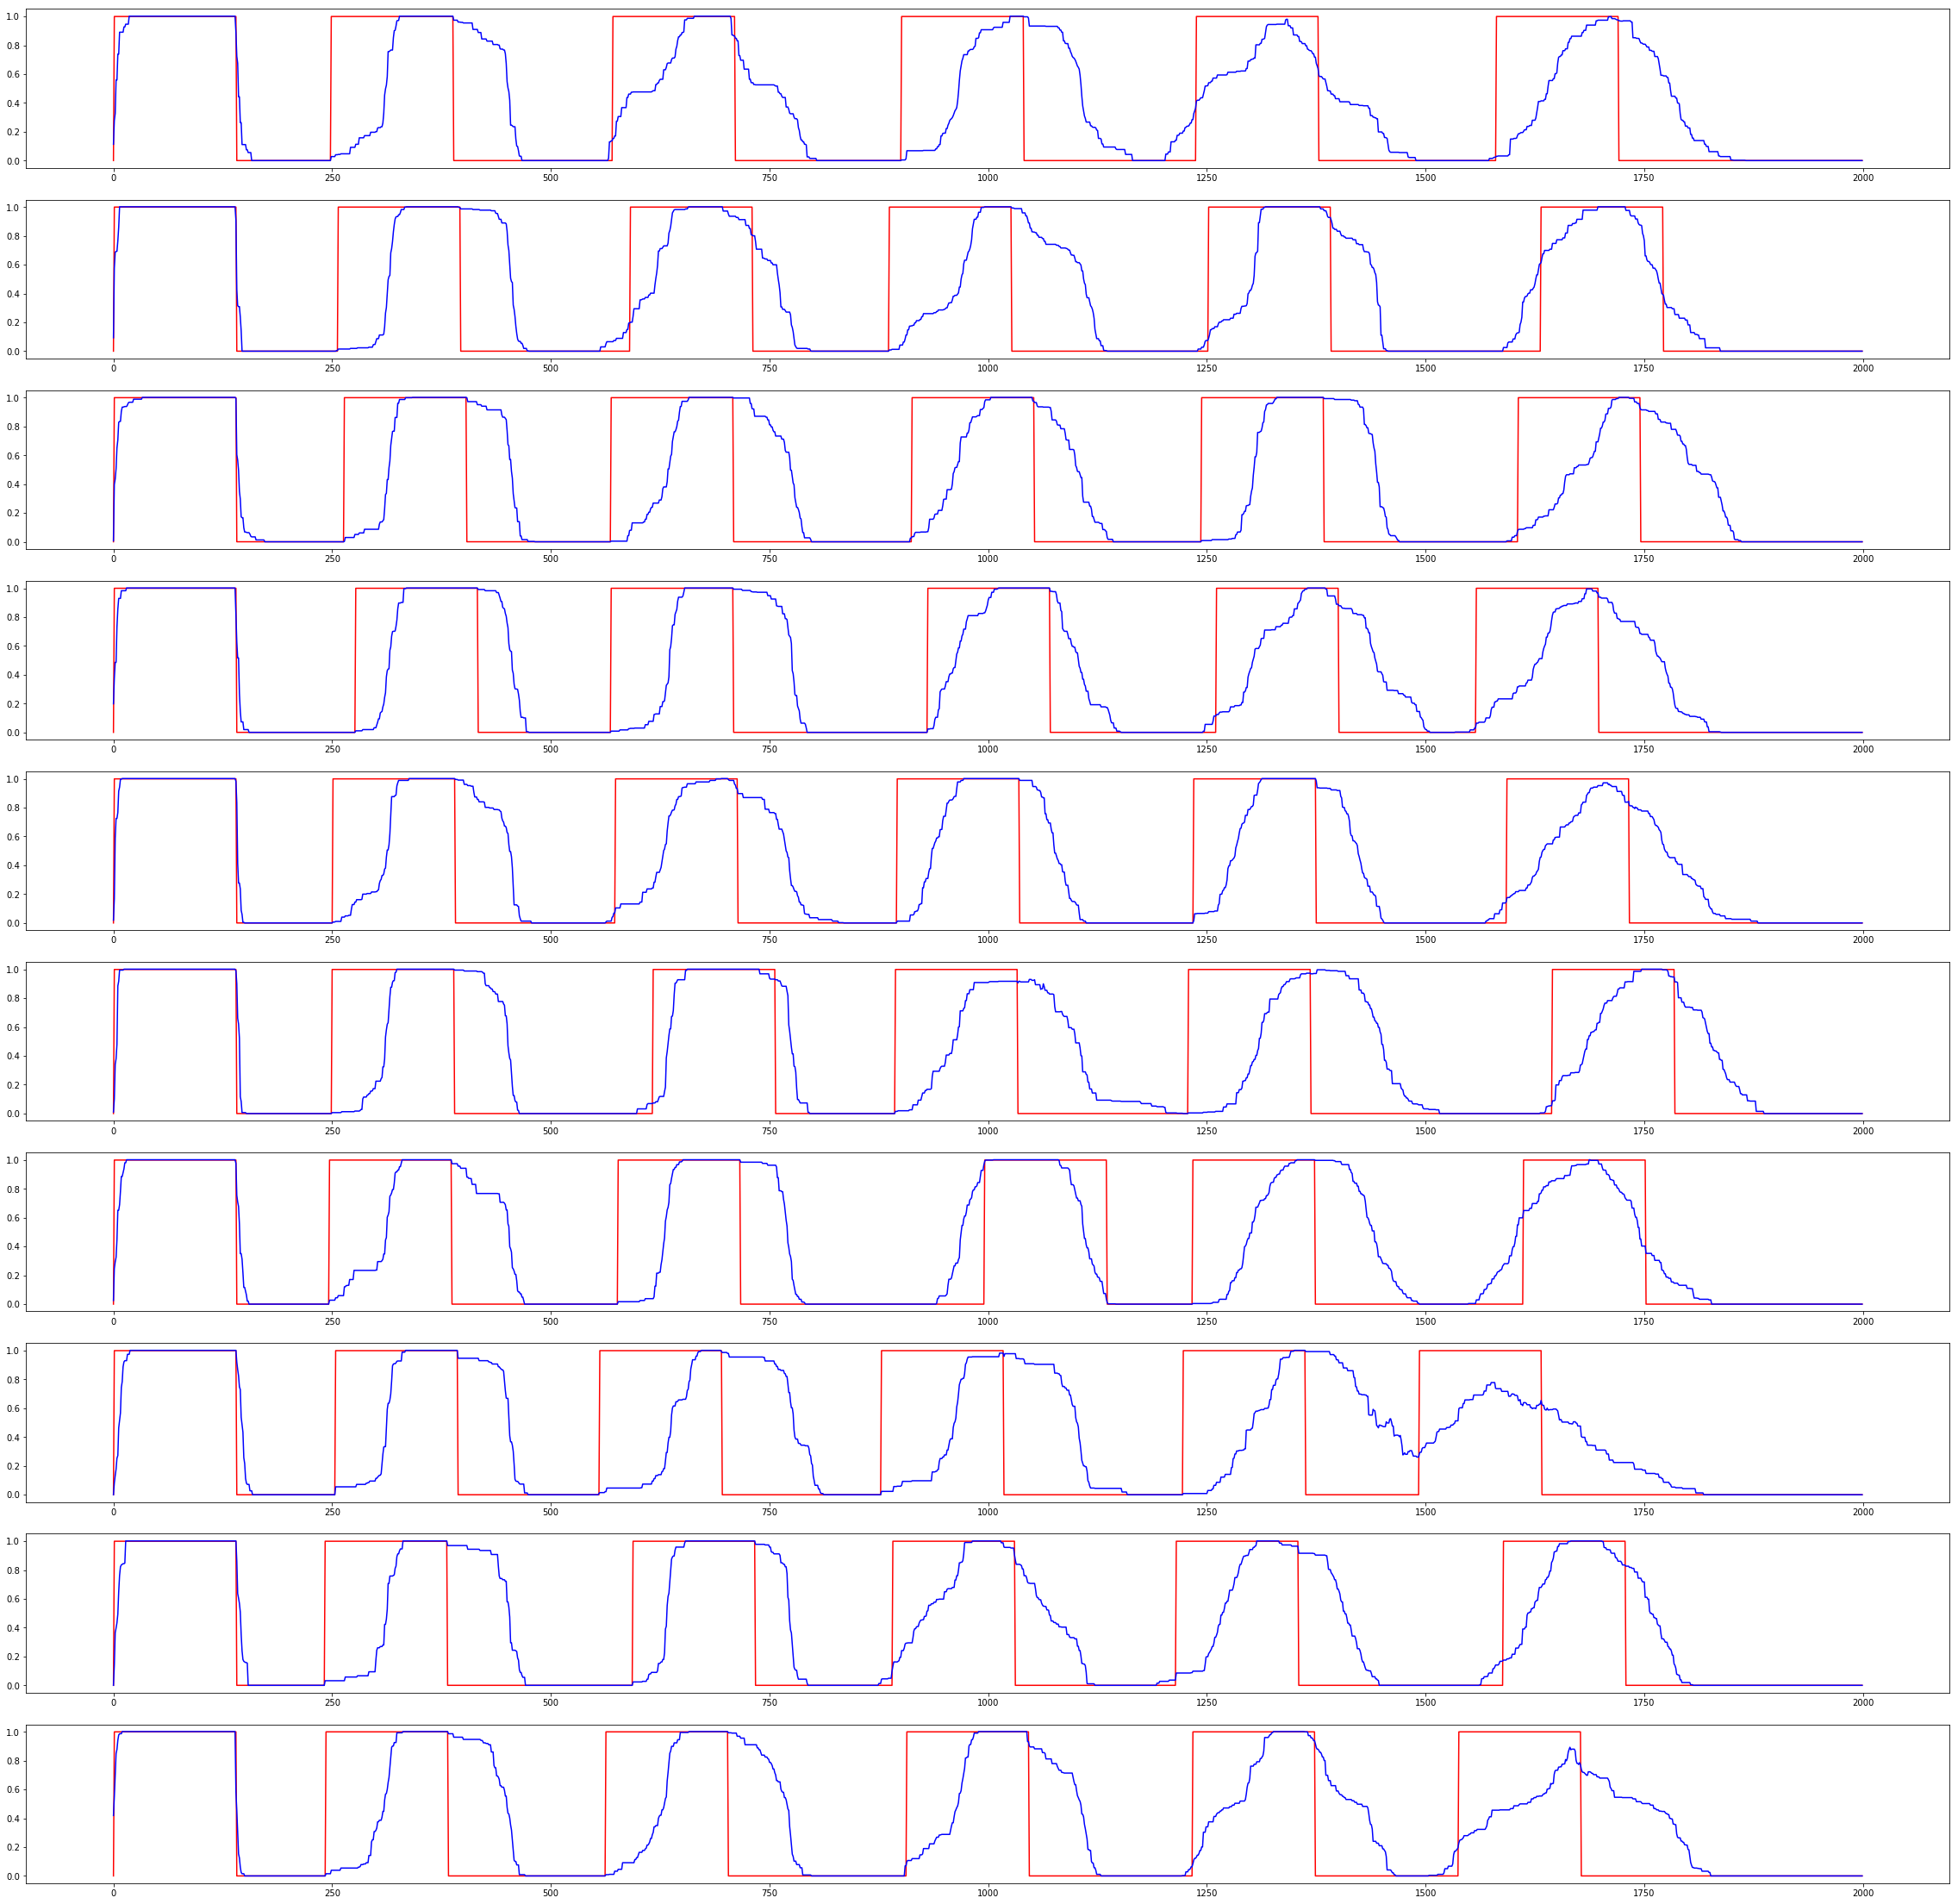

In [394]:
cycles = 10
gene = []
en = []
g = initializeGene(); gene.append(g)
gAv = []
for i in range(cycles):
    g = RNAP(g); gene.append(g); en.append(energy(g)); gAv.append(np.ceil(g/max(g)))
    g, e, gA = MCMC(g, 500, T); gene.append(g); en.extend(e); gAv.append(gA/len(e))

fig = plt.figure(figsize=(4*cycles, 4*cycles))
ind = 0; pltInd = 0
while ind < 2*cycles:
    ax = fig.add_subplot(cycles,1,pltInd+1)
    ax.plot(gAv[ind], 'r-')
    ax.plot(gAv[ind+1], 'b-')
    ind += 2; pltInd += 1
    
plt.show()

In [408]:
# check histone status (i.e. health of nucleosome)
def histone_check(g, h, printState = False):
    spc = detSpace(g)
    for i in spc.keys():
        if (i != 0 and i != int(max(g)) and spc[i] < HEALTH_CUT):
            # check if histones about to be removed are already gone
            if h[i][1] <= 0:
                del h[i] # remove nuclesome from histone list
                g[g==i] = 0 # remove nucleosome from gene
                if printState: print 'removed nuc ', i
            elif h[i+1][0] <= 0:
                del h[i+1] # remove nuclesome from histone list
                g[g==i+1] = 0 # remove nucleosome from gene
                if printState: print 'removed nuc ', i+1
            else:
                h[i][1] -= 1 # remove right histone of left nucleosome
                h[i+1][0] -= 1 # remove left histone of right nucloesome
                if printState: print 'removed left his from nuc ', i, 'and right from ', i+1
    return g, h

In [409]:
# define histone object for given gene
def initializeHistones(g = initializeGene()):
    keys = np.asarray(np.linspace(1, max(g), int(max(g))), int)
    h = {}
    for i in keys:
        h[i] = [1,1]
    return h

print initializeHistones()

{1: [1, 1], 2: [1, 1], 3: [1, 1], 4: [1, 1], 5: [1, 1], 6: [1, 1]}


In [410]:
cycles = 10
gene = []
en = []
g = initializeGene()
h = initializeHistones(g)
gene.append(g)
gAv = []
for i in range(cycles):
    g = RNAP(g); gene.append(g); en.append(energy(g)); gAv.append(np.ceil(g/max(g)))
    g, e, gA = MCMC(g, 100, T); gene.append(g); en.extend(e); gAv.append(gA/len(e))
    g, h = histone_check(g, h, printState=True)
    

removed left his from nuc  2.0 and right from  3.0
removed nuc  2.0


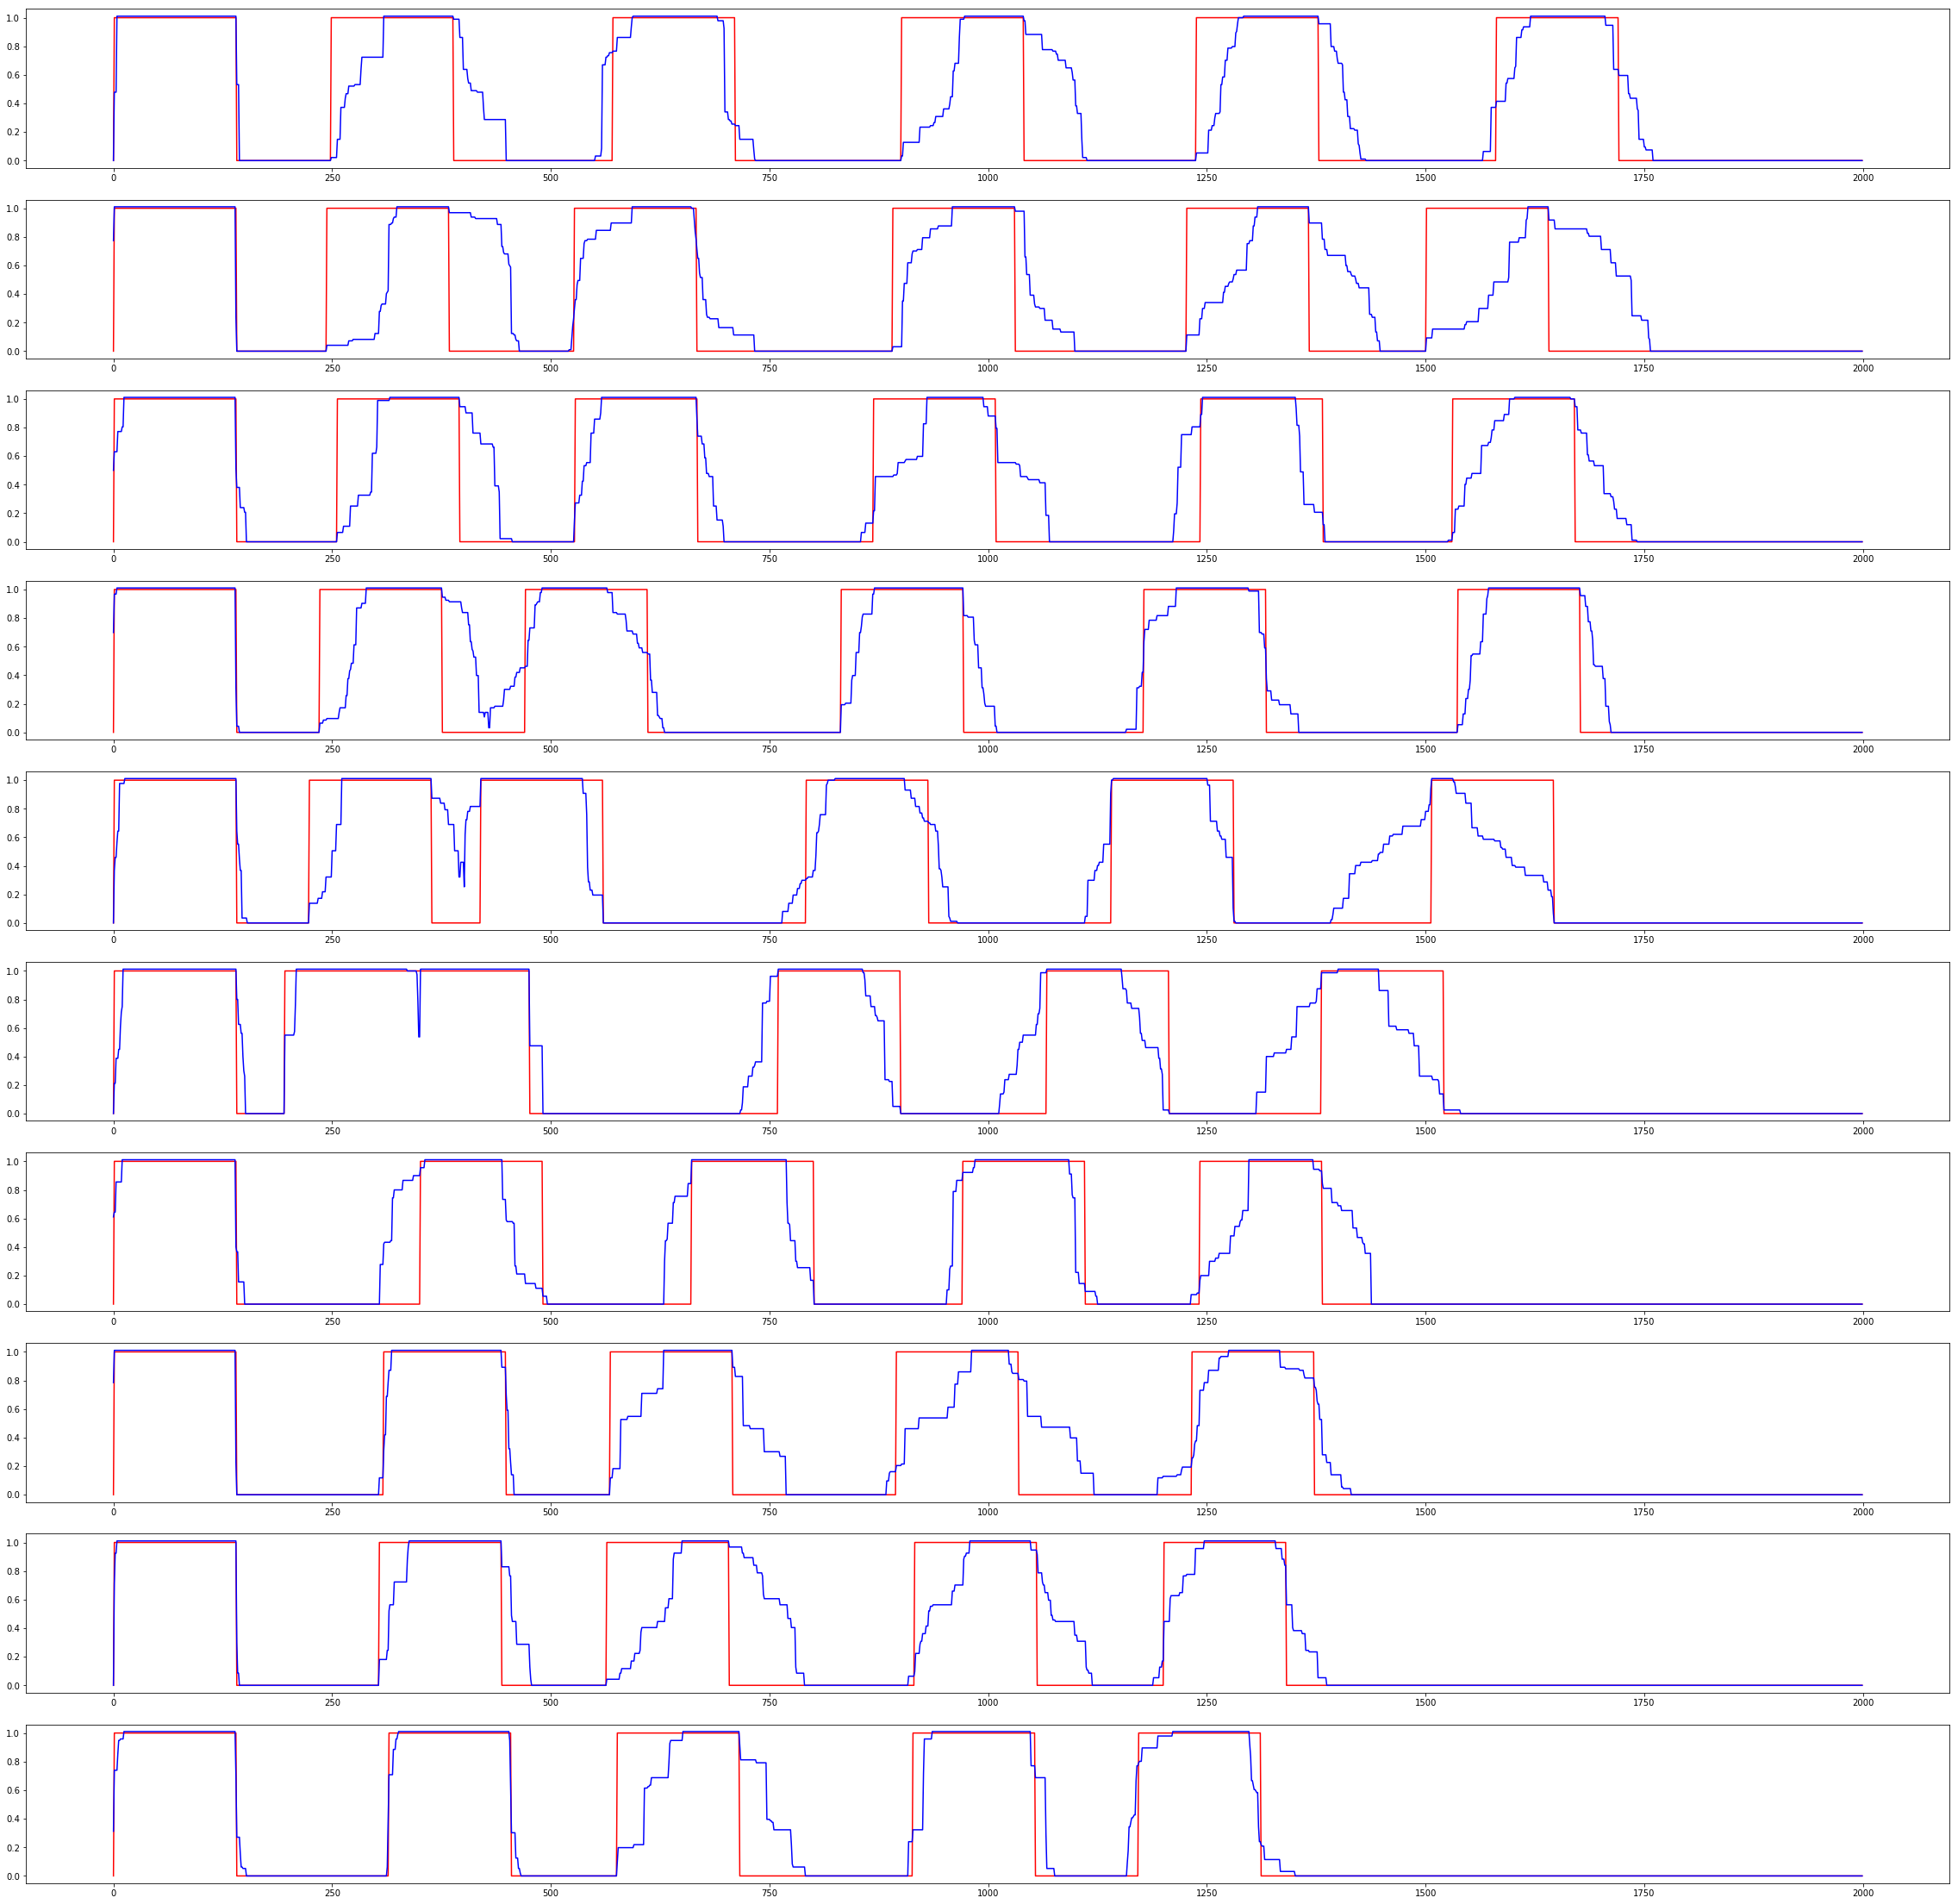

In [411]:
fig = plt.figure(figsize=(4*cycles, 4*cycles))
ind = 0; pltInd = 0
while ind < 2*cycles:
    ax = fig.add_subplot(cycles,1,pltInd+1)
    ax.plot(gAv[ind], 'r-')
    ax.plot(gAv[ind+1], 'b-')
    ind += 2; pltInd += 1
    
plt.show()